In [312]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [313]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

In [314]:
df = pd.read_excel("./app_build/MDSInc_sales.xlsx")
df.head()

,order_id,order_date,ship_date,ship_mode,customer_name,segment,state,country,market,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority
0,AG-2011-2040,2011-01-01 00:00:00,2011-06-01 00:00:00,Standard Class,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408,2,0.0,106.140,35.46,Medium
1,IN-2011-47883,2011-01-01 00:00:00,2011-08-01 00:00:00,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120,3,0.1,36.036,9.72,Medium
2,HU-2011-1220,2011-01-01 00:00:00,2011-05-01 00:00:00,Second Class,Annie Thurman,Consumer,Budapest,Hungary,EMEA,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66,4,0.0,29.640,8.17,High
3,IT-2011-3647632,2011-01-01 00:00:00,2011-05-01 00:00:00,Second Class,Eugene Moren,Home Office,Stockholm,Sweden,EU,North,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",45,3,0.5,-26.055,4.82,High
4,IN-2011-47883,2011-01-01 00:00:00,2011-08-01 00:00:00,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",114,5,0.1,37.770,4.70,Medium


In [315]:
df["order_date"] = pd.to_datetime(df["order_date"])

In [316]:
cleaned_df = df.groupby(df["order_date"]).sum().reset_index()
cleaned_df = cleaned_df.drop(["order_date", "discount", "profit"], axis=1)
cleaned_df.head()

,sales,quantity,shipping_cost
0,808,19,64.67
1,2457,54,342.17
2,12567,177,1328.16
3,2586,86,376.49
4,11481,154,1209.56


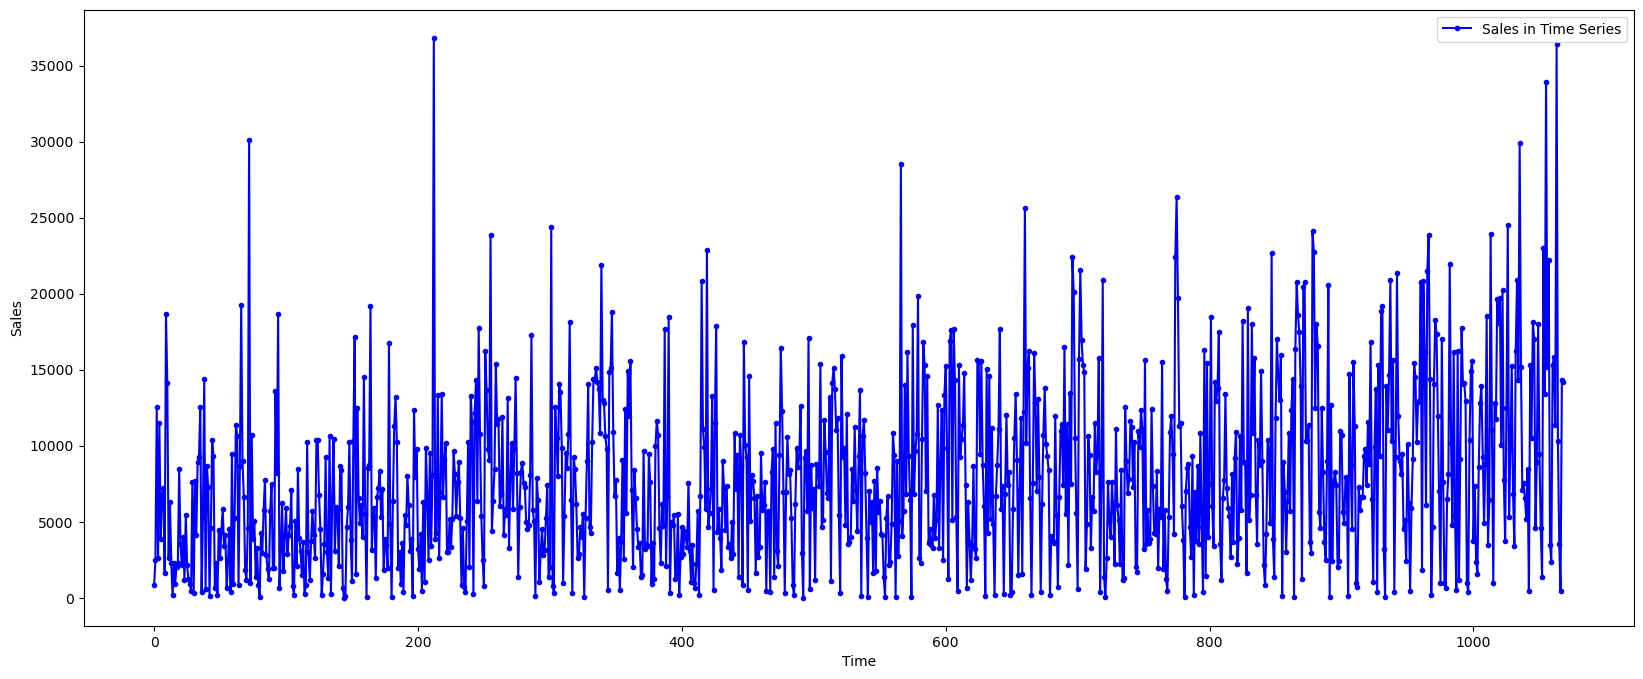

In [317]:
plt.figure(figsize=(20, 8))
plt.plot(cleaned_df.index, cleaned_df['sales'], 'b.-', label='Sales in Time Series')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()

In [318]:
model_df = StandardScaler().fit_transform(cleaned_df)
model_df[:2]

array([[-1.20648796, -1.2544257 , -1.21002678],
       [-0.92212612, -0.77244973, -0.77397255]])

In [319]:
train_X, train_y = model_df, model_df[2:, 0]
train_X.shape,train_y.shape

((1069, 3), (1067,))

In [320]:
model = keras.Sequential()
model.add(layers.GRU(
    units = 128,
    input_shape =(5,3)
))
model.add(layers.Dense(units = 1))
model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(0.001)
)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 128)               51072     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 51201 (200.00 KB)
Trainable params: 51201 (200.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [321]:
full_n = train_y.shape[0]
n = int(train_y.shape[0]*0.7)

In [322]:
train = keras.preprocessing.timeseries_dataset_from_array(train_X[:n],train_y[:n],sequence_length=5,batch_size=1) #train
test = keras.preprocessing.timeseries_dataset_from_array(train_X[n:],train_y[n:],sequence_length=5,batch_size=1) #test

In [323]:
test_x = np.array([i[0] for i in test])
test_x.resize(( full_n - n, 5, 3))

In [324]:
model.fit(train)
y_pred = model.predict(test_x)
y_pred.shape

11/11 [==============================] - 0s 1ms/step


(321, 1)

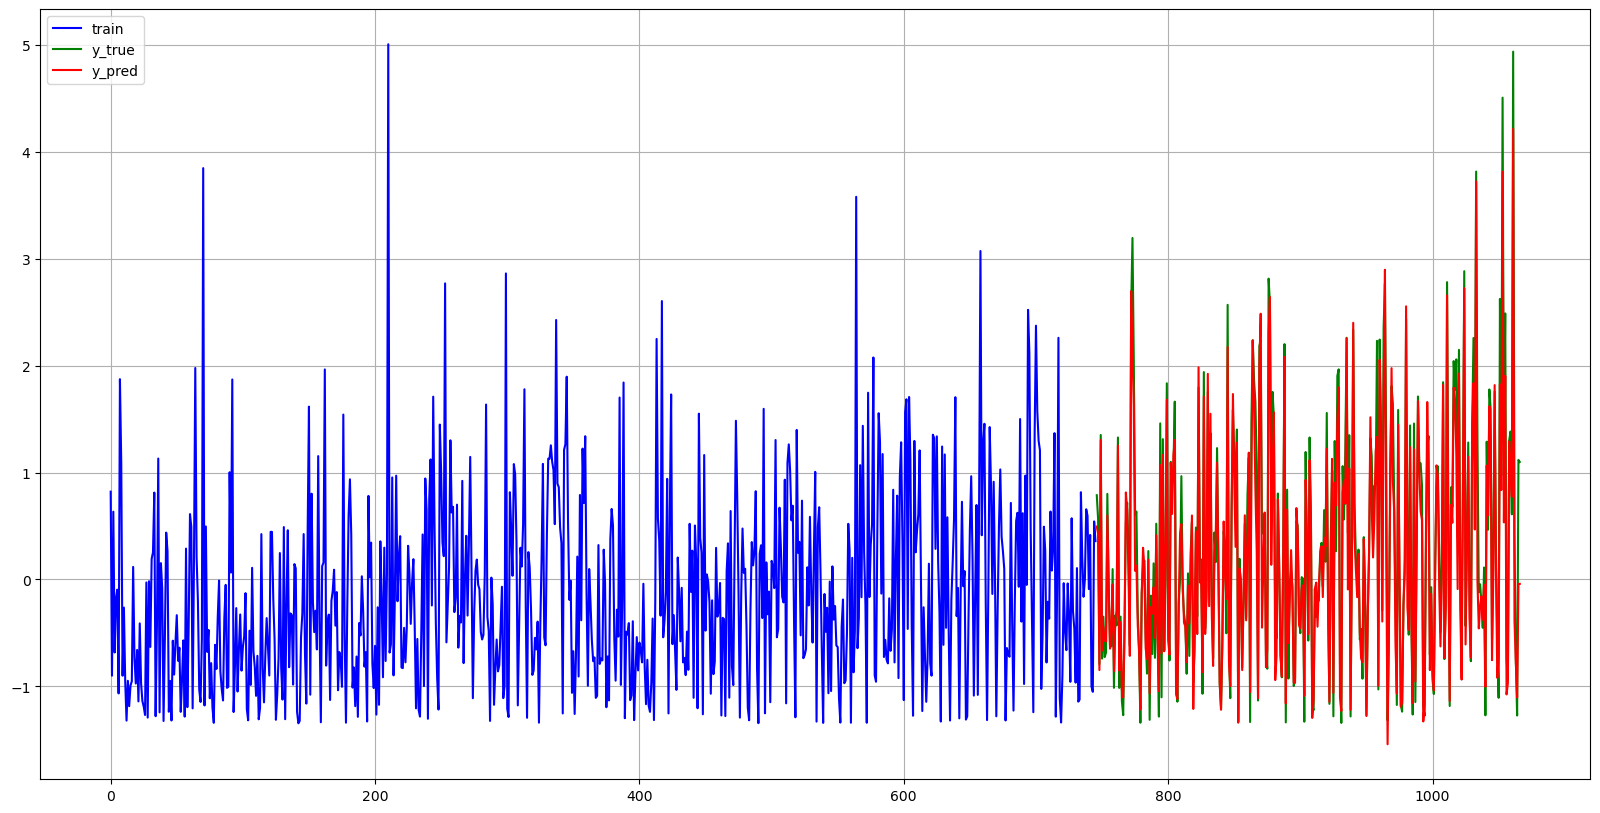

In [325]:
plt.figure(figsize=(20, 10))
plt.grid(which='major', axis='both', zorder=-0.5)
plt.plot( np.array(train_y)[:n],'b',label = 'train')
plt.plot(range(n,full_n),np.array(train_y)[n:],'g',label = 'y_true')
plt.plot(range(n,full_n), y_pred[:],'r',label = 'y_pred')
plt.legend()

In [326]:
r2_score( np.array(train_y)[n:],y_pred)

0.9283031547805793

---

In [327]:
df_2014 = pd.read_csv("./app_build/Q12_2014.csv")
df_2014["order_date"] = pd.to_datetime(df["order_date"])
df_2014 = df_2014.groupby("order_date").sum().reset_index()
dates = df_2014["order_date"].dt.strftime("%d-%b-%Y")

df_2014 = df_2014.drop(["order_date", "discount", "profit"], axis=1)
df_2014.head()

,sales,quantity,shipping_cost
0,2474,26,271.29
1,8181,41,836.65
2,9029,146,966.65
3,7513,83,854.26
4,21984,143,837.93


In [328]:
df_2014.shape

(295, 3)

In [329]:
model_df_2014 = StandardScaler().fit_transform(df_2014)
model_df_2014[:2]

array([[-0.63573302, -1.02421625, -0.56318897],
       [ 0.56358374, -0.73292781,  0.46611999]])

In [330]:
X, y = model_df_2014, model_df_2014[5:, 0]
X.shape,y.shape

((295, 3), (290,))

In [331]:
another_test = keras.preprocessing.timeseries_dataset_from_array(X,y,sequence_length=5,batch_size=1)

In [332]:
pred = model.predict(another_test)
pred.shape

290/290 [==============================] - 0s 557us/step


(290, 1)

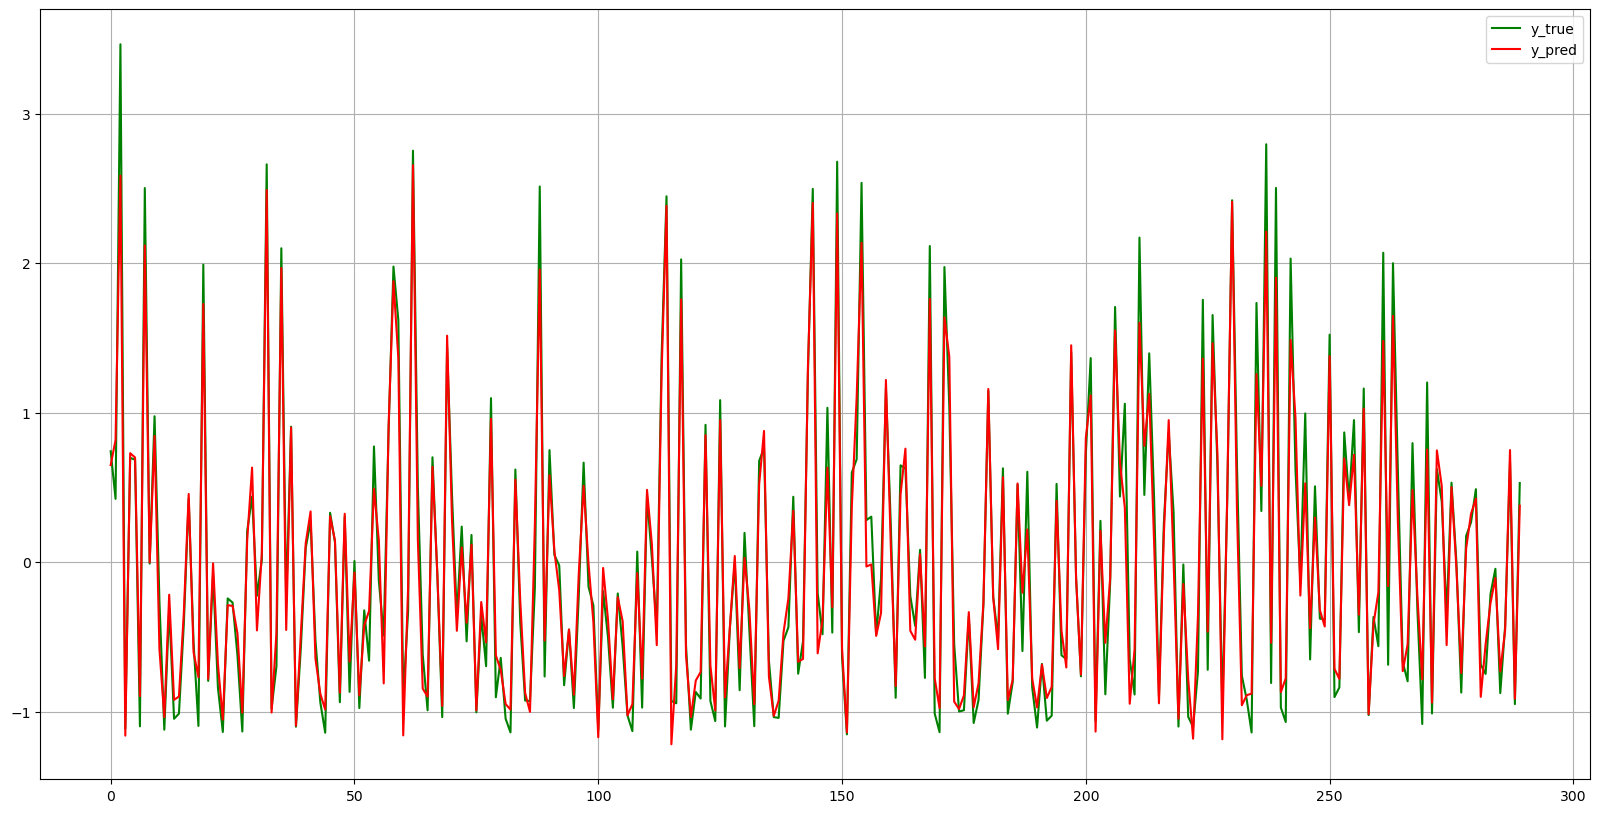

In [333]:
plt.figure(figsize=(20, 10))
plt.grid(which='major', axis='both', zorder=-0.5)
plt.plot(range(len(dates)-5),X[2:-3, 0],'g',label = 'y_true')
plt.plot(range(len(dates)-5), pred,'r',label = 'y_pred')
plt.legend()

In [334]:
r2_score(X[2:-3, 0], pred)

0.9552917603675866